## Setup of system

In [79]:
import numpy as np
np.set_printoptions(precision=2) # 2 decimals when printing arrays
np.set_printoptions(suppress=True) # No scientific notation for small numbers
import matplotlib.pyplot as plt
from scipy.integrate import complex_ode

from quantum_systems import ODQD, GeneralOrbitalSystem # library developed by Øyvind Schøyen and others, https://github.com/Schoyen/quantum-systems

In [80]:
l_0 = 10                # number of basis functions
grid_length = 10        # compute from x = -10 to x = 10 in 1D
num_grid_points = 2001
omega = 0.25            # strength of harmonic oscillator potential
n = 2                   # number of particles

# this sets up the harmonic oscillator basis functions and integrals between them
odho = ODQD(l_0, grid_length, num_grid_points, a = 0.25, alpha = 1, potential = ODQD.HOPotential(omega))

# this makes a spin up and spin down variant of the odho basis function and sets up the integrals between them
system = GeneralOrbitalSystem(n = n, basis_set=odho)
l = system.l

In [81]:
print(f"l = {system.l}")
print(f"grid shape = {system._basis_set.grid.shape}")
print(f"h shape = {system.h.shape}")
print(f"u shape = {system.u.shape}")
print(f"x shape = {system.position.shape}")
print(f"spf shape = {system.spf.shape}")

l = 20
grid shape = (2001,)
h shape = (20, 20)
u shape = (20, 20, 20, 20)
x shape = (1, 20, 20)
spf shape = (20, 2001)


In [82]:
np.diag(system.h.real)

array([0.12, 0.12, 0.37, 0.37, 0.62, 0.62, 0.87, 0.87, 1.12, 1.12, 1.38,
       1.38, 1.63, 1.63, 1.88, 1.88, 2.13, 2.13, 2.38, 2.38])

In [83]:
def getP(C):
    l = C.shape[0]
    P = np.zeros((l, l), dtype=complex)
    
    for g in range(l):
        for d in range(l):
            for i in range(n):
                P[d, g] += np.conj(C[g, i]) * C[d, i]
    return P

In [84]:
def getF(C):
    l = C.shape[0]
    F = np.zeros((l, l), dtype=complex)
    P = getP(C)
    
    for b in range(l):
        for a in range(l):
            F[b, a] += system.h[b, a]
            for g in range(l):
                for d in range(l):
                    F[b, a] += P[d, g] * system.u[b, g, a, d]
    return F

In [85]:
C = np.eye(l, dtype=complex)

In [112]:
for i in range(20):
    F = getF(C)
    vals, C = np.linalg.eigh(F)

In [113]:
gs = C[:, 0].real
print(gs)

[ 0.46  0.54 -0.44 -0.46 -0.18 -0.22  0.02  0.02 -0.02 -0.02 -0.   -0.
 -0.01 -0.01 -0.   -0.   -0.   -0.   -0.   -0.  ]


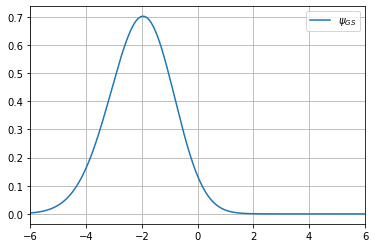

In [114]:
gs_vals = np.zeros(num_grid_points, dtype = complex)
for i in range(l):
    gs_vals += gs[i] * system.spf[i]
    
plt.plot(system.grid, np.abs(gs_vals)**2 / np.sum(np.abs(gs_vals)**2) * num_grid_points / 10, label=r"$\psi_{GS}$",) # why this normalization?
plt.xlim(-6, 6)

plt.grid()
plt.legend()
plt.show()

In [115]:
system.change_basis(C)
print(system.compute_reference_energy())
odho = ODQD(l_0, grid_length, num_grid_points, a = 0.25, alpha = 1, potential = ODQD.HOPotential(omega))
system = GeneralOrbitalSystem(n = n, basis_set=odho)

(0.8558027525971676+0j)


## TDHF

In [90]:
odho = ODQD(l_0, grid_length, num_grid_points, a = 0.25, alpha = 1, potential = ODQD.HOPotential(omega))
td_sys = GeneralOrbitalSystem(n = n, basis_set=odho)
td_sys.change_basis(C)

In [70]:
y0 = np.eye(l).reshape(-1)

t0 = 0
t1 = 10
dt = 0.01

In [71]:
N = int((t1 - t0) / dt) + 2

t = np.zeros(N)
t[0] = t0
y = np.zeros((N, y0.shape[0]), dtype=complex)
y[0] = y0

In [72]:
def laser(t):
    eps_0 = 1
    omega_e = 8 * omega
    return eps_0 * np.sin(omega_e * t)

def getFt(t, C):
    l = C.shape[0]
    F = np.zeros((l, l), dtype=complex)
    P = getP(C)
    
    F += td_sys.h
    F += td_sys.position[0] * laser(t)
    for b in range(l):
        for a in range(l):
            for g in range(l):
                for d in range(l):
                    F[b, a] += P[d, g] * td_sys.u[b, g, a, d]
    return F

In [73]:
def f(t, C):
    l = int(np.sqrt(C.shape[0]))
    C = C.reshape(l, l)
    F = getFt(t, C)
    Cdot = -1j * F @ C
    
    return Cdot.reshape(-1)

In [74]:
r = complex_ode(f).set_integrator('vode')
r.set_initial_value(y0, t0)

i = 1
while r.successful() and r.t < t1:
    t[i] = r.t + dt
    y[i] = r.integrate(r.t + dt)
    i += 1
    
t = t[:i]
y = y[:i]

In [109]:
C0 = y[1000, :].reshape(l, l)

gs = C0[:, 0]
print(gs)

[-0.87+0.45j -0.  +0.j    0.  +0.j    0.03+0.2j   0.03+0.01j -0.  -0.j
  0.  -0.j    0.02-0.01j  0.  +0.01j  0.  -0.j   -0.  +0.j   -0.  +0.j
 -0.  -0.j    0.  +0.j    0.  -0.j   -0.  +0.j   -0.  +0.j    0.  +0.j
 -0.  -0.j   -0.  -0.j  ]


In [110]:
np.abs(C0[:, 0])

array([0.98, 0.  , 0.  , 0.21, 0.03, 0.  , 0.  , 0.02, 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

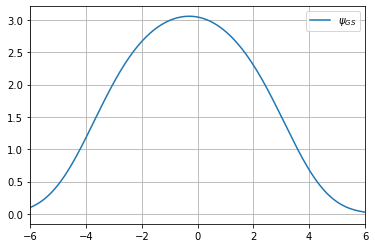

In [111]:
gs_vals = np.zeros(num_grid_points, dtype = complex)
for i in range(l):
    gs_vals += gs[i] * td_sys.spf[i]
    
plt.plot(td_sys.grid, np.abs(gs_vals)**2 / np.sum(np.abs(gs_vals)**2) * num_grid_points, label=r"$\psi_{GS}$",) # why this normalization?
plt.xlim(-6, 6)

plt.grid()
plt.legend()
plt.show()